### Dependencies & Prerequisites


In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=93acb0ccecadd00fc8548d4b77b7f420849f596898414abf9b7601aa37163e2f
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pyDOE import lhs
import tensorflow_probability as tfp

### Introduction
In this notebook, a physics informed neural network developed for one of the examples mentioned in this seminal paper [1]. tensorflow v2 was used and a simple function-based approch is selected to solve the problem. You can find a tensorflow v1 implementation here [2].

1. <a href="
https://doi.org/10.48550/arXiv.1711.10561">Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations </a>
2. https://maziarraissi.github.io/PINNs/

### Data Preparation
In this section, collection of data needed to train a PINN is prepared. Data consist of collocation points inside pde problem domain and also boundry and initial conditions.

In [ ]:
bc1_points = 25
bc2_points = 25

x0_bc1 = -1*np.ones((bc1_points,))
x0_bc2 = np.ones((bc2_points,))

t0_bc1 = np.linspace(0,1,bc1_points)
t0_bc2 = np.linspace(0,1,bc2_points)

u0_bc1 = np.zeros((bc1_points,))
u0_bc2 = np.zeros((bc2_points,))

In [ ]:
ic_points  = 50

x0_ic = np.linspace(-1,1,ic_points)
t0_ic = np.zeros(ic_points)
u0_ic = -np.sin(np.pi*x0_ic)

In [ ]:
x0 = np.hstack([x0_ic,x0_bc1,x0_bc2]).reshape(-1,1).astype(np.float32)
t0 = np.hstack([t0_ic,t0_bc1,t0_bc2]).reshape(-1,1).astype(np.float32)
u0 = np.hstack([u0_ic,u0_bc1,u0_bc2]).reshape(-1,1).astype(np.float32)

In [ ]:
collocation_points = 10000;
lb = np.array([0,-1])
ub = np.array([1,1])

data =lb + (ub-lb)*lhs(2, collocation_points)

# boundry and initial points should also obey pde
tc = data[:,0]
xc = data[:,1]
# # preparation to be used in a neural net
tc = tc.reshape(-1,1).astype(np.float32)
xc = xc.reshape(-1,1).astype(np.float32)

In [ ]:
tc = np.vstack([t0,tc])
xc = np.vstack([x0,xc])

In [ ]:
t0 = tf.convert_to_tensor(t0)
x0 = tf.convert_to_tensor(x0)
u0 = tf.convert_to_tensor(u0)
tc = tf.convert_to_tensor(tc)
xc = tf.convert_to_tensor(xc)

### Neural Network Specification

In [ ]:
# custom layer for scaling data based on the upper (ub) and lower (lb) bounds
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, lb, ub, **kwargs):
        super().__init__(**kwargs)
        self.lb = lb
        self.ub = ub

    def call(self, inputs):
        return 2.0*(inputs - self.lb)/(self.ub - self.lb) - 1.0

In [ ]:
model = tf.keras.Sequential([
    ScaleLayer(lb, ub),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(20,activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')
])

In [ ]:
def mse_f(t,x):
    c=1
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(t)
      tape.watch(x)

      u = model(tf.concat([t,x],axis=1))
      u_x = tape.gradient(u,x)
      u_t = tape.gradient(u,t)
    u_xx = tape.gradient(u_x, x)
    u_tt = tape.gradient(u_t,t)
    del tape
    return tf.reduce_mean(tf.square(u_t + u*u_x - (0.01/np.pi)*u_xx));

In [ ]:
def mse_u(t0,x0,u0):
    u0_pred = model(tf.concat([t0,x0],axis=1))
    return tf.reduce_mean(tf.square(u0-u0_pred))

In [ ]:
@tf.function()
def compute_loss(t,x,t0,x0,u0):
    print('Tracing') # checking for graph execution
    return mse_f(t,x) + mse_u(t0,x0,u0)

In [ ]:
# this line just randomly initialize the weights on tensorflow model
model(t0,x0);

In [ ]:
# to be able to feed the optimizer with weights we have to flatten weights and biases
# and then feed them to optimizer and after that to set weights for the nn model we have
# to rearrange weights and biases again
w_start = tf.concat( [ tf.reshape(t, [-1]) for t in model.get_weights()] , 0)
w_shape = [ t.shape for t in model.get_weights()]

In [ ]:
def loss_and_gradient_net(w0):
  counter = 0
  w_n = []
  for s in w_shape:
    n=np.prod(s)
    w_n.append( tf.reshape(w0[counter:counter+n],s) )
    counter+=n
  model.set_weights(w_n)
  del w_n
  with tf.GradientTape() as tape:
    loss = compute_loss(tc,xc,t0,x0,u0)

  grad = tape.gradient(loss, model.trainable_variables)
  # print(grad)
  grad = tf.concat( [ tf.reshape(t, [-1]) for t in grad] , 0)
  return loss, grad

In [ ]:
loss_and_gradient_net(w_start)

Tracing


(<tf.Tensor: shape=(), dtype=float32, numpy=0.6317215>,
 <tf.Tensor: shape=(3021,), dtype=float32, numpy=
 array([ 0.00314984,  0.11650954,  0.2099103 , ...,  0.22954947,
        -0.6902945 , -0.22388004], dtype=float32)>)

In [ ]:
optim_results = tfp.optimizer.lbfgs_minimize(
    loss_and_gradient_net,
    initial_position=w_start,
    num_correction_pairs=10,
    max_iterations=3000,
    tolerance=1e-6)

In [ ]:
loss_and_gradient_net(optim_results.position)

(<tf.Tensor: shape=(), dtype=float32, numpy=8.9932066e-05>,
 <tf.Tensor: shape=(3021,), dtype=float32, numpy=
 array([-2.6910153e-04, -1.9550449e-04, -5.7910005e-05, ...,
        -7.3086718e-05, -3.8641563e-05, -1.7544659e-04], dtype=float32)>)

### Results

In [ ]:
# plot
d_t = 0.01
d_x = 0.01
x_v = np.arange(-1, 1, d_t)
t_v = np.arange(0, 1, d_x)
X, T = np.meshgrid(x_v, t_v)
_shape = X.shape

In [ ]:
X = X.reshape(-1,1).astype(np.float32)
T = T.reshape(-1,1).astype(np.float32)
u_pred = model(tf.concat([T,X],axis=1))
X, T = np.meshgrid(x_v, t_v)
u_pred=u_pred.numpy().reshape(X.shape)

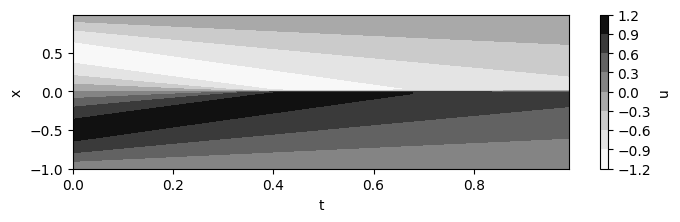

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(8, 2))
plt.xlabel('t'); plt.ylabel('x')
CS = axs.contourf(T, X, u_pred, cmap = 'Greys')
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('u');

In [ ]:
x_v1 = tf.convert_to_tensor(x_v.reshape(-1,1).astype(np.float32))

y_025=model(tf.concat([tf.ones_like(x_v1)*0.25,x_v1],axis=1))
y_05=model(tf.concat([tf.ones_like(x_v1)*0.5,x_v1],axis=1))
y_075=model(tf.concat([tf.ones_like(x_v1)*0.75,x_v1],axis=1))

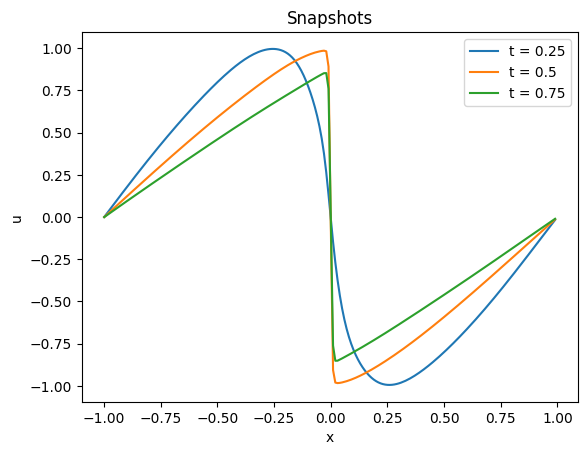

In [ ]:

plt.plot(x_v1,y_025,label="t = 0.25")
plt.plot(x_v1,y_05, label="t = 0.5")
plt.plot(x_v1,y_075, label="t = 0.75")
plt.legend()
plt.title('Snapshots');
plt.xlabel('x'); plt.ylabel('u');
